### 导入相关库

In [69]:
import copy

# Importing the basic libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as pdb
import os
plt.style.use('seaborn-darkgrid')

In [70]:
# Loading the data. 查看当前目录下的文件
print(os.listdir('./'))

['demo.py', 'Image', 'main.ipynb', 'penguins.csv']


### 导入数据

In [71]:
data = pd.read_csv("./penguins.csv")

### 数据探索

In [72]:
data.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


In [73]:
data.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [74]:
data_profile = pdb.ProfileReport(data)
data_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


从该报告可得知，存在19个缺失值，其中Sex标签有11个缺失值。
总共的样本数为344个，并不多。因此，将Sex缺失标签去除，其余缺失值由均值填充。

In [76]:
data.dropna(axis=0, how="any", subset=["sex"], inplace=True)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


本想把“Sex”缺失删除后，其余缺失值由均值填充。
在剔除“Sex”缺失值对应行时，其余缺失值刚好在被剔除行中。
接下来，将类型为Object离散特征转换为独热编码

In [78]:
dummy = pd.get_dummies(data[['species', 'island', 'sex']])

In [79]:
data = data.drop('species', axis=1)
data = data.drop('island', axis=1)
data = data.drop('sex', axis=1)

data = data.join(dummy)

In [80]:
data = data.drop('sex_female', axis=1)
# sex_male为1表示男性，为0表示女性
data.head(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,1,0,0,0,0,1,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,0,1,0
2,40.3,18.0,195.0,3250.0,1,0,0,0,0,1,0
4,36.7,19.3,193.0,3450.0,1,0,0,0,0,1,0
5,39.3,20.6,190.0,3650.0,1,0,0,0,0,1,1


数据处理好后，查看数据分布

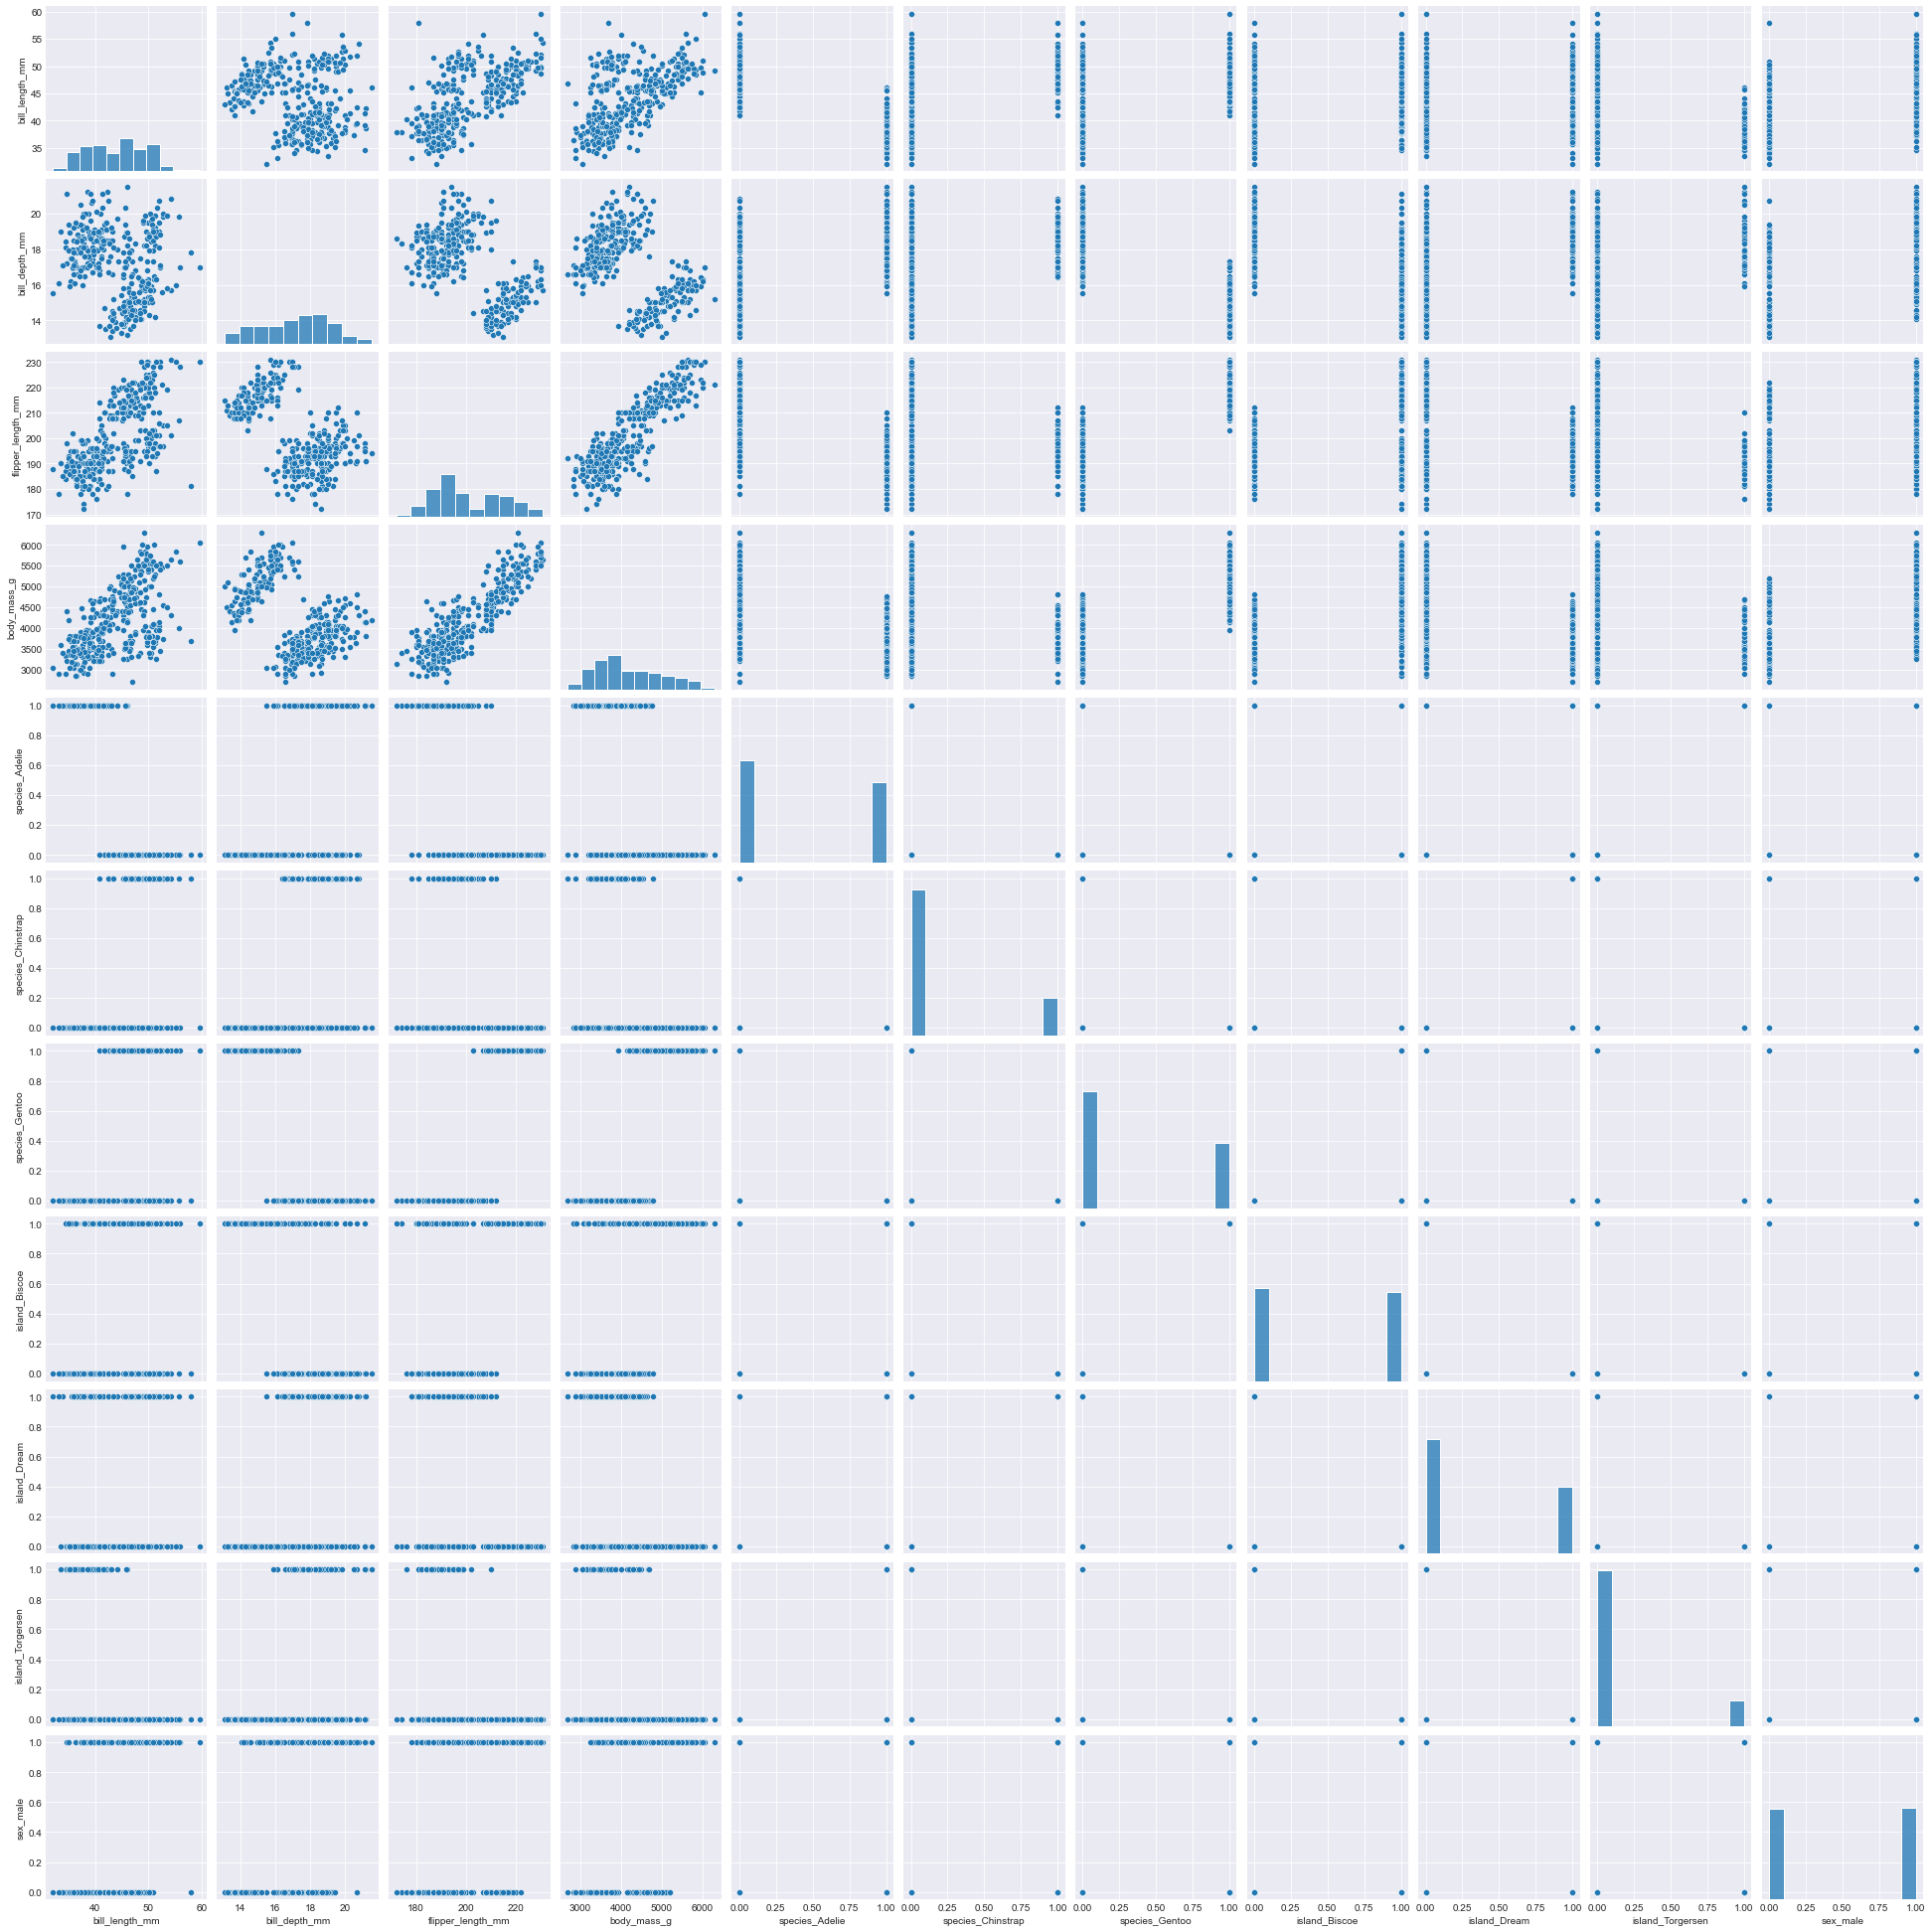

In [81]:
sns.pairplot(data)
plt.show()

查看相关性

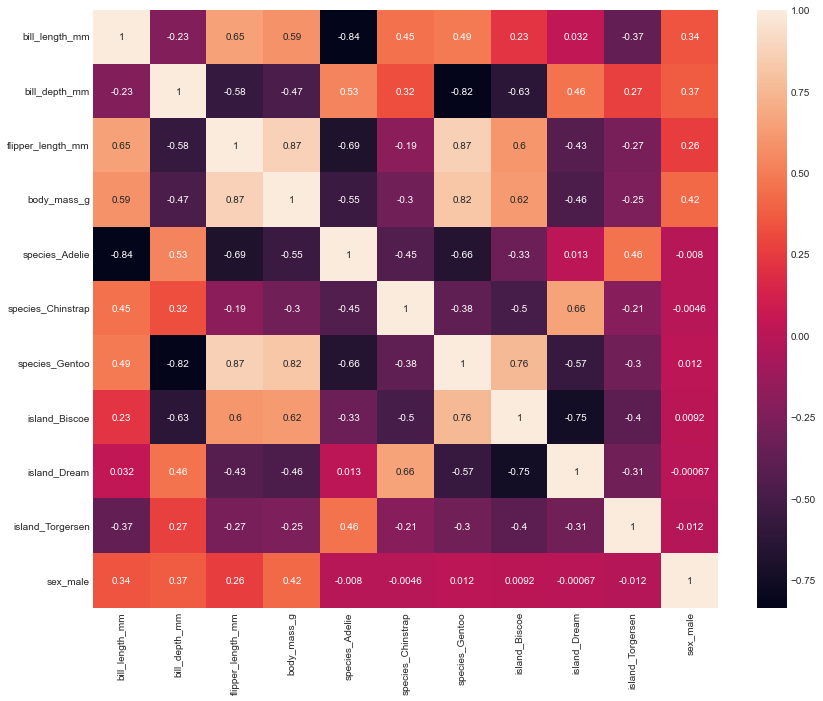

In [82]:
# creating heatmap
plt.figure(figsize=(14,11))
sns.heatmap(data.corr(), annot=True)
plt.show()

### 划分特征与标签

In [83]:
import copy

label = data['sex_male']
data = data.drop(columns='sex_male', axis=1)
data.head(1)
Raw_data = copy.deepcopy(data)  # 深拷贝，否则Raw_data会随data变化而变化

### 数据预处理(仅对连续特征进行标准化)

In [84]:
from sklearn.preprocessing import StandardScaler

# 标准归一化
data = np.array(data)
scaler = StandardScaler()
data[:, :4] = scaler.fit_transform(data[:, :4])

### 评价指标

In [85]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def Result(acc, precision, f1, recall, roc_auc):  #　评价指标
    print("Acc:{0}, Precision:{1}, F1:{2}, Recall:{3}, Roc_auc:{4}".format(round(np.mean(acc), 4), round(np.mean(precision), 4), round(np.mean(f1), 4), round(np.mean(recall), 4), round(np.mean(roc_auc), 4)))

def train_test(clf, x, y):
    acc = cross_val_score(clf, x, y, cv=5)
    precision = cross_val_score(clf, x, y, cv=5, scoring="precision_weighted")
    f1 = cross_val_score(clf, x, y, cv=5, scoring="f1_weighted")
    recall = cross_val_score(clf, x, y, cv=5, scoring="recall_weighted")
    roc_auc = cross_val_score(clf, x, y, cv=5, scoring="roc_auc")
    Result(acc, precision, f1, recall, roc_auc)

### 逻辑回归
为了更好的评价模型的泛化性能，这里使用五折交叉验证对数据集训练测试。

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
train_test(logreg, data, label)

Acc:0.8737, Precision:0.8891, F1:0.8718, Recall:0.8737, Roc_auc:0.9725


### SVM

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC(kernel='linear')
train_test(clf, data, label)

Acc:0.8889, Precision:0.8979, F1:0.8883, Recall:0.8889, Roc_auc:0.9735


### SVM参数网络搜索

In [88]:
from sklearn.model_selection import GridSearchCV

parameters = [{'C': [1, 3, 5, 7, 9, 11, 13],
	    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100],
	    'kernel': ['rbf']},
	{'C': [0.5, 1, 3, 5, 7],
	    'kernel': ['linear']}]

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(data, label)
print(clf.best_params_)
best_clf = clf.best_estimator_
print(best_clf)

{'C': 9, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=9, gamma=0.1)


In [89]:
clf = best_clf
train_test(clf, data, label)

Acc:0.8948, Precision:0.9026, F1:0.8942, Recall:0.8948, Roc_auc:0.975


### 决策树(Gini)

In [90]:
from sklearn.tree import DecisionTreeClassifier #Decision Tree

DTC = DecisionTreeClassifier(criterion="gini")
train_test(DTC, data, label)

Acc:0.7716, Precision:0.8375, F1:0.7324, Recall:0.7989, Roc_auc:0.7661


### 决策树(Entropy)

In [91]:
from sklearn.tree import DecisionTreeClassifier #Decision Tree

DTC = DecisionTreeClassifier(criterion="entropy")
train_test(DTC, data, label)

Acc:0.82, Precision:0.8336, F1:0.8093, Recall:0.823, Roc_auc:0.8235


## 优化决策树模型

### Pre-pruning
Pre pruning is nothing but stoping the growth of decision tree on an early stage. For that we can limit the growth of trees by setting constrains. We can limit parameters like max_depth , min_samples etc.

An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data.

In [92]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [1,2,3,4],
         'min_samples_leaf': [1,2]}

DTC1 = DecisionTreeClassifier(criterion='entropy')
clf = GridSearchCV(estimator=DTC1, param_grid=params)
clf.fit(data, label)
print(clf.best_params_)
best_clf = clf.best_estimator_
print(best_clf)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2)


In [93]:
clf = best_clf
train_test(clf, data, label)

Acc:0.8468, Precision:0.8699, F1:0.8235, Recall:0.8529, Roc_auc:0.8537


### PCA + SVM

In [94]:
from sklearn.decomposition import PCA

model = PCA()
model.fit(data)
transformed = model.transform(data)
print("Principle components: ", model.components_)

Principle components:  [[ 3.96386181e-01 -3.90343584e-01  5.25798570e-01  5.00041758e-01
  -2.12482103e-01 -3.57381505e-02  2.48220253e-01  1.90699973e-01
  -1.21949911e-01 -6.87500620e-02]
 [ 6.57303470e-01  5.22216035e-01  3.14528707e-02  9.20376764e-03
  -1.88605851e-01  3.24134918e-01 -1.35529066e-01 -2.21493060e-01
   2.86211718e-01 -6.47186583e-02]
 [-1.94528818e-01  6.54493540e-01  2.02551982e-01  5.10796246e-01
   2.90407254e-01 -2.57950864e-01 -3.24563905e-02  7.38790253e-02
  -2.26334642e-01  1.52455616e-01]
 [-3.99838314e-01 -6.72662721e-02  2.49389495e-01  2.67431457e-01
   1.35934590e-02 -1.98986193e-02  6.30516029e-03 -3.68753515e-01
   6.83025252e-01 -3.14271738e-01]
 [-2.78236393e-02 -1.10044244e-01  3.82873097e-01 -1.71550988e-01
  -7.34762395e-03  1.90043151e-02 -1.16566912e-02 -5.80997812e-01
  -9.95048401e-02  6.80502652e-01]
 [-1.58139538e-01  2.38393143e-01  6.67800356e-01 -5.65571668e-01
  -5.06552043e-02  4.88190875e-02  1.83611672e-03  2.91181836e-01
  -4.50945

[3.26913674e+00 1.00242227e+00 5.17277378e-01 1.56504217e-01
 1.46302603e-01 1.01475507e-01 4.81420149e-02 1.69432571e-02
 1.93804952e-32 3.52116223e-33]
[6.21721172e-01 1.90639669e-01 9.83752968e-02 2.97638162e-02
 2.78236834e-02 1.92985110e-02 9.15560047e-03 3.22225176e-03
 3.68576328e-33 6.69651128e-34]


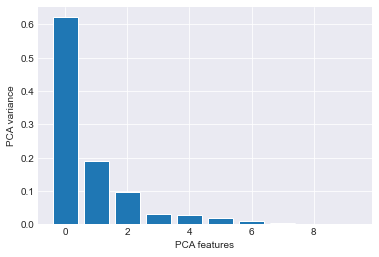

In [95]:
# PCA variance
pca = PCA()
pca.fit(data)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel("PCA features")
plt.ylabel("PCA variance")
plt.show()

### PCA及可解释性方差确定维度（具体推导）

In [96]:
cov_mat = np.cov(data.T)
# 计算特征值、特征向量
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print("Eigenvalues \n%s" %eig_vals)

Eigenvalues 
[ 3.26913674e+00  1.00242227e+00  5.17277378e-01  1.56504217e-01
  1.46302603e-01  1.01475507e-01  4.81420149e-02  1.69432571e-02
 -8.29280624e-17  3.31978523e-16]


In [97]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)
print("Eigenvalues in descending order:")
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.2691367449504902
1.0024222650347823
0.5172773777872973
0.156504216866528
0.1463026030759876
0.10147550742713375
0.04814201490726525
0.016943257070170623
3.3197852302578584e-16
8.292806239843428e-17


In [98]:
total = sum(eig_vals)
var_exp = [(i/total)*100 for i in sorted(eig_vals, reverse=True)]

print(len(var_exp))

10


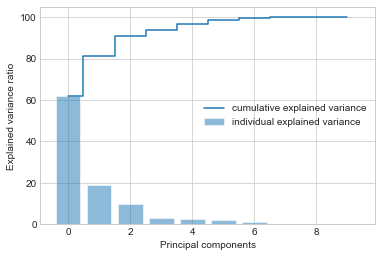

In [99]:
cum_var_exp = np.cumsum(var_exp)
with plt.style.context("seaborn-whitegrid"):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), var_exp, alpha=0.5, align="center", label="individual explained variance")
    plt.step(range(10), cum_var_exp, where="mid", label="cumulative explained variance")
    plt.ylabel("Explained variance ratio")
    plt.xlabel("Principal components")
    plt.legend(loc="best")
    plt.tight_layout

In [100]:
pca1 = PCA(n_components=4)
data_pca = pca1.fit_transform(data)
print(pca1.n_components_, "\n", pca1.explained_variance_ratio_)

4 
 [0.62172117 0.19063967 0.0983753  0.02976382]


In [101]:
print(data_pca.shape, label.shape)

(333, 4) (333,)


In [102]:
parameters = [{'C': [1, 3, 5, 7, 9],
	    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100],
	    'kernel': ['rbf']},
	{'C': [1, 3, 5, 7, 9, 11],
	    'kernel': ['linear']}]

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(data_pca, label)
print(clf.best_params_)
best_clf = clf.best_estimator_
print(best_clf)

{'C': 3, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=3, gamma=1)


In [103]:
clf = best_clf
train_test(clf, data_pca, label)

Acc:0.8769, Precision:0.8851, F1:0.8762, Recall:0.8769, Roc_auc:0.9221


### 研究离散变量与归一化关系
数据集中有“species”和“island”两个离散变量，任务是分类性别任务。对于这两个离散变量对标签的影响、归一化处理对标签的影响不得而知，因此做以下实验来解惑。
主要分为两类：
A：表示类别变量转化为离散型变量，对所有维度归一化处理；B：表示类别变量转化为离散型变量，仅对连续特征维度归一化处理；C：表示类别变量直接剔除。
归一化处理方式：
1：正规化处理
2：最大最小归一化

用上述最佳模型进行处理（SVM高斯核）

### Baseline
A表示将类别变量转化为离散变量，不进行归一化处理

In [108]:
clf = SVC(C=1, kernel="linear")
train_test(clf, Raw_data, label)

Acc:0.8919, Precision:0.9052, F1:0.8907, Recall:0.8919, Roc_auc:0.9746


### Baseline
B表示将类别变量剔除，不进行归一化处理

In [109]:
Raw_data = np.array(Raw_data)
Raw_data1 = Raw_data[:, :4]
train_test(clf, Raw_data1, label)

Acc:0.8466, Precision:0.8787, F1:0.8405, Recall:0.8466, Roc_auc:0.9685


表明，两个类别特征对于分类还是十分关键的。

In [110]:
from sklearn.preprocessing import Normalizer, MinMaxScaler

Raw_data = np.array(Raw_data)
scaler = Normalizer()
A1 = copy.deepcopy(Raw_data)
A1 = scaler.fit_transform(A1)

B1 = copy.deepcopy(Raw_data)
B1[:, :4] = scaler.fit_transform(B1[:, :4])

C1 = copy.deepcopy(Raw_data[:, :4])
C1 = scaler.fit_transform(C1)

scaler = MinMaxScaler()
A2 = copy.deepcopy(Raw_data)
A2 = scaler.fit_transform(A2)

B2 = copy.deepcopy(Raw_data)
B2[:, :4] = scaler.fit_transform(B2[:, :4])

C2 = copy.deepcopy(Raw_data[:, :4])
C2 = scaler.fit_transform(C2)

### A1 正规化处理

In [154]:
train_test(clf, A1, label)
print(A1[:2, :])
train_test(clf, B1, label)
train_test(clf, C1, label)
print(C1[:2, :])

Acc:0.5045, Precision:0.2545, F1:0.3383, Recall:0.5045, Roc_auc:0.868
[[1.04138478e-02 4.98053592e-03 4.82073263e-02 9.98770573e-01
  2.66338820e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.66338820e-04]
 [1.03816383e-02 4.57317737e-03 4.88856891e-02 9.98739885e-01
  2.62826286e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.62826286e-04]]
Acc:0.5403, Precision:0.4338, F1:0.4176, Recall:0.5403, Roc_auc:0.7409
Acc:0.5045, Precision:0.2545, F1:0.3383, Recall:0.5045, Roc_auc:0.868
[[0.01041385 0.00498054 0.04820733 0.99877064]
 [0.01038164 0.00457318 0.04888569 0.99873995]]


### B1

In [113]:
train_test(clf, A2, label)
train_test(clf, B2, label)
train_test(clf, C2, label)

Acc:0.88, Precision:0.8933, F1:0.8788, Recall:0.88, Roc_auc:0.9721
Acc:0.88, Precision:0.8933, F1:0.8788, Recall:0.88, Roc_auc:0.9721
Acc:0.8647, Precision:0.884, F1:0.8628, Recall:0.8647, Roc_auc:0.9659
